In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
from glob import glob
import matplotlib.image as mpimg
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, BatchNormalization, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet152V2, Xception, DenseNet201
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential, load_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [74]:
dataset_dir = 'Datasets/'
no_tumor_images=os.listdir(image_directory + 'no')
yes_tumor_images=os.listdir(image_directory + 'yes')


In [75]:
count_normal = 0
count_having_tumor = 0
for filename in yes_tumor_images:
    if not filename.startswith('.'):
        count_having_tumor += 1
for filename in no_tumor_images:
    if not filename.startswith('.'):
        count_normal += 1

In [76]:
print('images labelled as tumor: ', count_having_tumor)
print('\nimages labelled as normal: ', count_normal)
print('\ntotal images: ', count_having_tumor + count_normal)

images labelled as tumor:  1500

images labelled as normal:  1500

total images:  3000


In [77]:
def process(filename: str=None) -> None:
    image = mpimg.imread(filename)
    plt.figure()
    plt.imshow(image)

i=0

for filename in yes_tumor_images:
    if i<10:
        process(yes_tumor_images + '/' + filename)
        i += 1
    else:
        break

TypeError: can only concatenate list (not "str") to list

In [78]:
# Function for Image preprocessing
def processDataset(dataset_src, dataset_dest):
    # Making a Copy of Dataset
    shutil.copytree(dataset_src, dataset_dest)
    for folder in os.listdir(dest):
        for (index, filen) in enumerate(os.listdir(os.path.join(dest, folder)), start = 1):
            filename = f'{folder}_brain-tumor_{index}.jpg'
            img_src = os.path.join(dest, folder, filename)
            img_des = os.path.join(dest, folder, filename)

            # Preprocess the Images
            img = cv2.imread(img_src,)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.GaussianBlur(img, (3,3), sigmaX=0)
            img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
            cv2.imwrite(img_des ,img)
            os.remove(img_src)

src = dataset_dir
dest = './BrainTumorDataset'
processDataset(src, dest)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: './BrainTumorDataset'

In [79]:
BrainTumorDataset_dir = os.getcwd() + "/BrainTumorDataset"
f = BrainTumorDataset_dir + '/yes'

In [80]:
count_having_tumor=0
for filename in os.listdir(f):
    if not filename.startswith('.'):
        count_having_tumor += 1
print(count_having_tumor)

1500


In [81]:
## Function for Creating Train / Validation / Test folders (One time use Only)
 
def TrainValTestSplit(root_dir, classes_dir, val_ratio = 0.15, test_ratio = 0.15):
    main_folder = './BrainTumor_Splited_Data/';

    for cls in classes_dir:
        os.makedirs(main_folder + 'train' + cls)
        os.makedirs(main_folder + 'val' + cls)
        os.makedirs(main_folder + 'test' + cls)

        src = root_dir + cls
        
        allFileNames = os.listdir(src)
        print(allFileNames)
        np.random.seed(0)
        np.random.shuffle(allFileNames)

        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), int(len(allFileNames)* (1 - test_ratio))])

        train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
        val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
        test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

        print(cls.upper(),':')
        print('Total images: ', len(allFileNames))
        print('Training: ', len(train_FileNames))
        print('Validation: ', len(val_FileNames))
        print('Testing: ', len(test_FileNames))

        for name in train_FileNames:
            shutil.copy(name, main_folder + 'train' + cls)

        for name in val_FileNames:
            shutil.copy(name, main_folder + 'val' + cls)

        for name in test_FileNames:
            shutil.copy(name, main_folder + 'test' + cls)
        print()

root_dir = BrainTumorDataset_dir              
classes_dir = ['/no', '/yes'] 
TrainValTestSplit(root_dir, classes_dir)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: './BrainTumor_Splited_Data/train/no'

In [82]:
BrainTumor_Splited_Data_dir = os.getcwd() + "/BrainTumor_Splited_Data"

In [83]:
## Image Data Augmentation

train_datagen = ImageDataGenerator(rescale=1/255,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   brightness_range=[0.3,1.5],
                                   horizontal_flip=True,
                                   vertical_flip=True)

val_datagen = image.ImageDataGenerator(rescale = 1./255)

test_datagen = image.ImageDataGenerator(rescale = 1./255)

TRAIN_DIR = BrainTumor_Splited_Data_dir + "/train"
VAL_DIR = BrainTumor_Splited_Data_dir + "/val"
TEST_DIR = BrainTumor_Splited_Data_dir + "/test"

In [84]:
training_set = train_datagen.flow_from_directory(TRAIN_DIR,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical',
                                                shuffle=False)

validation_set = val_datagen.flow_from_directory(VAL_DIR,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical',
                                                shuffle=False)

testing_set = test_datagen.flow_from_directory(TEST_DIR,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical',
                                              shuffle=False)

Found 2100 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 450 images belonging to 2 classes.


In [85]:
image_size =[224, 224]

#  Inception Deep Learning Model

In [86]:
inception = InceptionV3(input_shape = image_size + [3], include_top = False, weights = 'imagenet')

In [87]:
for layer in inception.layers:
    layer.trainable=False

In [88]:
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D

In [89]:
x = (inception.output)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
prediction=Dense(2, activation='softmax')(x)

model2 = Model(inputs=inception.input, outputs=prediction)

In [90]:
model2.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(0.001),
    metrics=['accuracy']
)

In [110]:
# model2.summary()

In [40]:
filepath = 'inception_best_model.hdf5'
checkpoint =tf.keras.callbacks.ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1,save_best_only=True,
                             save_weights_only=False,
                             mode= 'max')
callbacks = [checkpoint]

In [43]:
r2 = model2.fit(
    training_set,batch_size=32,
    validation_data=validation_set,
    epochs = 100,
    steps_per_epoch = training_set.samples//training_set.batch_size,
    validation_steps = validation_set.samples//validation_set.batch_size,
    callbacks=[callbacks]
)

Epoch 1/100
65/65 [==============================] - ETA: 0s - loss: 0.9423 - accuracy: 0.5706
Epoch 1: val_accuracy improved from -inf to 0.80804, saving model to inception_best_model.hdf5
65/65 [==============================] - 94s 1s/step - loss: 0.9423 - accuracy: 0.5706 - val_loss: 0.5305 - val_accuracy: 0.8080
Epoch 2/100
65/65 [==============================] - ETA: 0s - loss: 0.5743 - accuracy: 0.7258
Epoch 2: val_accuracy improved from 0.80804 to 0.85491, saving model to inception_best_model.hdf5
65/65 [==============================] - 94s 1s/step - loss: 0.5743 - accuracy: 0.7258 - val_loss: 0.4322 - val_accuracy: 0.8549
Epoch 3/100
65/65 [==============================] - ETA: 0s - loss: 0.4972 - accuracy: 0.7708
Epoch 3: val_accuracy did not improve from 0.85491
65/65 [==============================] - 97s 1s/step - loss: 0.4972 - accuracy: 0.7708 - val_loss: 0.4391 - val_accuracy: 0.8237
Epoch 4/100
65/65 [==============================] - ETA: 0s - loss: 0.4213 - accura

Epoch 29/100
65/65 [==============================] - ETA: 0s - loss: 0.2184 - accuracy: 0.9096
Epoch 29: val_accuracy did not improve from 0.95982
65/65 [==============================] - 93s 1s/step - loss: 0.2184 - accuracy: 0.9096 - val_loss: 0.1368 - val_accuracy: 0.9554
Epoch 30/100
65/65 [==============================] - ETA: 0s - loss: 0.1719 - accuracy: 0.9371
Epoch 30: val_accuracy did not improve from 0.95982
65/65 [==============================] - 94s 1s/step - loss: 0.1719 - accuracy: 0.9371 - val_loss: 0.1765 - val_accuracy: 0.9219
Epoch 31/100
65/65 [==============================] - ETA: 0s - loss: 0.1871 - accuracy: 0.9342
Epoch 31: val_accuracy did not improve from 0.95982
65/65 [==============================] - 95s 1s/step - loss: 0.1871 - accuracy: 0.9342 - val_loss: 0.1673 - val_accuracy: 0.9353
Epoch 32/100
65/65 [==============================] - ETA: 0s - loss: 0.1882 - accuracy: 0.9313
Epoch 32: val_accuracy did not improve from 0.95982
65/65 [==============

65/65 [==============================] - ETA: 0s - loss: 0.1275 - accuracy: 0.9584
Epoch 58: val_accuracy did not improve from 0.97768
65/65 [==============================] - 94s 1s/step - loss: 0.1275 - accuracy: 0.9584 - val_loss: 0.1373 - val_accuracy: 0.9598
Epoch 59/100
65/65 [==============================] - ETA: 0s - loss: 0.1327 - accuracy: 0.9531
Epoch 59: val_accuracy did not improve from 0.97768
65/65 [==============================] - 91s 1s/step - loss: 0.1327 - accuracy: 0.9531 - val_loss: 0.0967 - val_accuracy: 0.9688
Epoch 60/100
65/65 [==============================] - ETA: 0s - loss: 0.1450 - accuracy: 0.9444
Epoch 60: val_accuracy did not improve from 0.97768
65/65 [==============================] - 91s 1s/step - loss: 0.1450 - accuracy: 0.9444 - val_loss: 0.1022 - val_accuracy: 0.9688
Epoch 61/100
65/65 [==============================] - ETA: 0s - loss: 0.1459 - accuracy: 0.9473
Epoch 61: val_accuracy did not improve from 0.97768
65/65 [===========================

65/65 [==============================] - 93s 1s/step - loss: 0.1649 - accuracy: 0.9299 - val_loss: 0.1574 - val_accuracy: 0.9464
Epoch 88/100
65/65 [==============================] - ETA: 0s - loss: 0.1391 - accuracy: 0.9550
Epoch 88: val_accuracy did not improve from 0.98214
65/65 [==============================] - 92s 1s/step - loss: 0.1391 - accuracy: 0.9550 - val_loss: 0.1098 - val_accuracy: 0.9643
Epoch 89/100
65/65 [==============================] - ETA: 0s - loss: 0.1229 - accuracy: 0.9512
Epoch 89: val_accuracy did not improve from 0.98214
65/65 [==============================] - 93s 1s/step - loss: 0.1229 - accuracy: 0.9512 - val_loss: 0.1141 - val_accuracy: 0.9576
Epoch 90/100
65/65 [==============================] - ETA: 0s - loss: 0.1243 - accuracy: 0.9545
Epoch 90: val_accuracy did not improve from 0.98214
65/65 [==============================] - 92s 1s/step - loss: 0.1243 - accuracy: 0.9545 - val_loss: 0.1062 - val_accuracy: 0.9688
Epoch 91/100
65/65 [====================

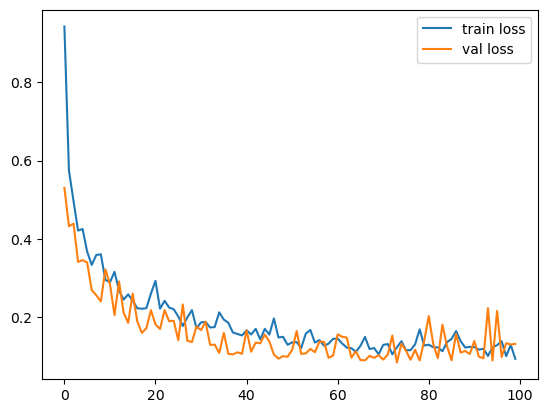

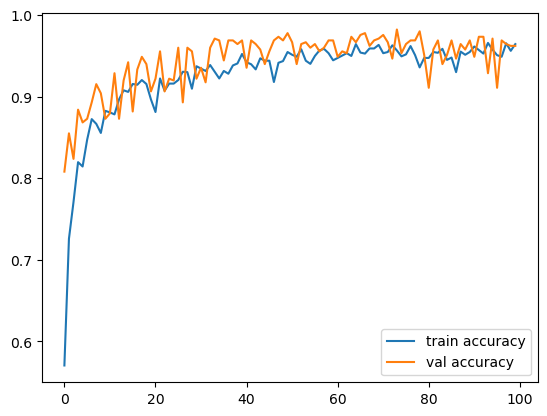

<Figure size 640x480 with 0 Axes>

In [44]:
plt.plot(r2.history['loss'], label='train loss')
plt.plot(r2.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss_inception')

plt.plot(r2.history['accuracy'], label='train accuracy')
plt.plot(r2.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('LossVal_inception')

In [ ]:
model2 = load_model(filepath)

In [45]:
accuracy_cnn2_test = model2.evaluate_generator(generator= testing_set)[1]
accuracy_cnn2_test

C:\Users\kumar\AppData\Local\Temp\ipykernel_27096\4224899135.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_cnn2_test = model2.evaluate_generator(generator= testing_set)[1]


0.9688888788223267

In [46]:
accuracy_cnn2_train = model2.evaluate_generator(generator= training_set)[1]
accuracy_cnn2_train

C:\Users\kumar\AppData\Local\Temp\ipykernel_27096\221604947.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_cnn2_train = model2.evaluate_generator(generator= training_set)[1]


0.9828571677207947

In [47]:
accuracy_cnn2_val = model2.evaluate_generator(generator= validation_set)[1]
accuracy_cnn2_val

C:\Users\kumar\AppData\Local\Temp\ipykernel_27096\751803031.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_cnn2_val = model2.evaluate_generator(generator= validation_set)[1]


0.9622222185134888

# Resnet152V2

In [93]:
resnet = ResNet152V2(input_shape = image_size + [3], include_top = False, weights = 'imagenet')

In [94]:
for layer in resnet.layers:
    layer.trainable=False

In [95]:
x = (resnet.output)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
prediction=Dense(2, activation='softmax')(x)

model3 = Model(inputs=resnet.input, outputs=prediction)

In [96]:
model3.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(0.001),
    metrics=['accuracy']
)

In [97]:
model3.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
          

                                                                 ]                                
                                                                                                  
 conv3_block5_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block5_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block5_2_pad (ZeroPaddin  (None, 30, 30, 128)  0          ['conv3_block5_1_relu[0][0]']    
 g2D)                                                                                             
          

 conv3_block7_out (Add)         (None, 28, 28, 512)  0           ['conv3_block6_out[0][0]',       
                                                                  'conv3_block7_3_conv[0][0]']    
                                                                                                  
 conv3_block8_preact_bn (BatchN  (None, 28, 28, 512)  2048       ['conv3_block7_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv3_block8_preact_relu (Acti  (None, 28, 28, 512)  0          ['conv3_block8_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv3_block8_1_conv (Conv2D)   (None, 28, 28, 128)  65536       ['conv3_block8_preact_relu[0][0]'
          

                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block2_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  589824      ['conv4_block2_2_pad[0][0]']     
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

                                )                                 'conv4_block4_3_conv[0][0]']    
                                                                                                  
 conv4_block5_preact_bn (BatchN  (None, 14, 14, 1024  4096       ['conv4_block4_out[0][0]']       
 ormalization)                  )                                                                 
                                                                                                  
 conv4_block5_preact_relu (Acti  (None, 14, 14, 1024  0          ['conv4_block5_preact_bn[0][0]'] 
 vation)                        )                                                                 
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262144      ['conv4_block5_preact_relu[0][0]'
                                                                 ]                                
          

                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 14, 14, 256)  589824      ['conv4_block7_2_pad[0][0]']     
                                                                                                  
 conv4_block7_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block7_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block7_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block7_2_relu[0][0]']    
          

 ivation)                       )                                                                 
                                                                                                  
 conv4_block10_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block10_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block10_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block10_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block10_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block10_1_bn[0][0]']     
 on)                                                                                              
          

 conv4_block12_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block12_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block12_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block12_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block12_out (Add)        (None, 14, 14, 1024  0           ['conv4_block11_out[0][0]',      
                                )                                 'conv4_block12_3_conv[0][0]']   
                                                                                                  
 conv4_block13_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block12_out[0][0]']      
 Normaliza

 lization)                                                                                        
                                                                                                  
 conv4_block15_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block15_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block15_2_pad (ZeroPaddi  (None, 16, 16, 256)  0          ['conv4_block15_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block15_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block15_2_pad[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block17_out (Add)        (None, 14, 14, 1024  0           ['conv4_block16_out[0][0]',      
                                )                                 'conv4_block17_3_conv[0][0]']   
                                                                                                  
 conv4_block18_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block17_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_block18_preact_relu (Act  (None, 14, 14, 1024  0          ['conv4_block18_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block18_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block18_preact_relu[0][0]
          

 ng2D)                                                                                            
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block20_2_pad[0][0]']    
                                                                                                  
 conv4_block20_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block20_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block20_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block23_preact_relu (Act  (None, 14, 14, 1024  0          ['conv4_block23_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block23_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block23_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block23_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block23_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block23_1_bn[0][0]']     
 on)      

                                                                                                  
 conv4_block25_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block25_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block25_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block25_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block25_out (Add)        (None, 14, 14, 1024  0           ['conv4_block24_out[0][0]',      
                                )                                 'conv4_block25_3_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block28_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block28_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block28_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block28_2_pad (ZeroPaddi  (None, 16, 16, 256)  0          ['conv4_block28_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block28_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block28_2_pad[0][0]']    
          

                                                                                                  
 conv4_block30_out (Add)        (None, 14, 14, 1024  0           ['conv4_block29_out[0][0]',      
                                )                                 'conv4_block30_3_conv[0][0]']   
                                                                                                  
 conv4_block31_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block30_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_block31_preact_relu (Act  (None, 14, 14, 1024  0          ['conv4_block31_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_blo

 conv4_block33_2_pad (ZeroPaddi  (None, 16, 16, 256)  0          ['conv4_block33_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block33_2_pad[0][0]']    
                                                                                                  
 conv4_block33_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block33_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block33_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block33_2_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block36_preact_relu (Act  (None, 14, 14, 1024  0          ['conv4_block36_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block36_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block36_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block36_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block36_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 7, 7, 512)    2359296     ['conv5_block2_2_pad[0][0]']     
                                                                                                  
 conv5_block2_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
          

In [21]:
filepath = 'resnet_best_model.hdf5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                 save_weights_only=False,
                                                 verbose=1, monitor="val_accuracy", 
                                                 mode="max", save_best_only=True)

In [23]:
r3 = model3.fit(
    training_set,
    batch_size=32,
    validation_data=validation_set,
    epochs = 100,
    steps_per_epoch = training_set.samples//training_set.batch_size,
    validation_steps = validation_set.samples//validation_set.batch_size,
    callbacks=[cp_callback]
)

Epoch 1/100
65/65 [==============================] - ETA: 0s - loss: 0.3773 - accuracy: 0.8443
Epoch 1: val_accuracy improved from -inf to 0.93750, saving model to resnet_best_model.hdf5
65/65 [==============================] - 334s 5s/step - loss: 0.3773 - accuracy: 0.8443 - val_loss: 0.2170 - val_accuracy: 0.9375
Epoch 2/100
65/65 [==============================] - ETA: 0s - loss: 0.2895 - accuracy: 0.8738
Epoch 2: val_accuracy did not improve from 0.93750
65/65 [==============================] - 339s 5s/step - loss: 0.2895 - accuracy: 0.8738 - val_loss: 0.2034 - val_accuracy: 0.9152
Epoch 3/100
65/65 [==============================] - ETA: 0s - loss: 0.2168 - accuracy: 0.9202
Epoch 3: val_accuracy improved from 0.93750 to 0.94420, saving model to resnet_best_model.hdf5
65/65 [==============================] - 345s 5s/step - loss: 0.2168 - accuracy: 0.9202 - val_loss: 0.1542 - val_accuracy: 0.9442
Epoch 4/100
65/65 [==============================] - ETA: 0s - loss: 0.1827 - accuracy:

65/65 [==============================] - 338s 5s/step - loss: 0.0383 - accuracy: 0.9845 - val_loss: 0.0674 - val_accuracy: 0.9844
Epoch 30/100
65/65 [==============================] - ETA: 0s - loss: 0.0522 - accuracy: 0.9826
Epoch 30: val_accuracy did not improve from 0.98438
65/65 [==============================] - 336s 5s/step - loss: 0.0522 - accuracy: 0.9826 - val_loss: 0.0740 - val_accuracy: 0.9777
Epoch 31/100
65/65 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.9855
Epoch 31: val_accuracy did not improve from 0.98438
65/65 [==============================] - 338s 5s/step - loss: 0.0392 - accuracy: 0.9855 - val_loss: 0.1390 - val_accuracy: 0.9509
Epoch 32/100
65/65 [==============================] - ETA: 0s - loss: 0.0594 - accuracy: 0.9836
Epoch 32: val_accuracy did not improve from 0.98438
65/65 [==============================] - 343s 5s/step - loss: 0.0594 - accuracy: 0.9836 - val_loss: 0.0952 - val_accuracy: 0.9621
Epoch 33/100
65/65 [================

Epoch 59/100
65/65 [==============================] - ETA: 0s - loss: 0.0369 - accuracy: 0.9889
Epoch 59: val_accuracy did not improve from 0.98661
65/65 [==============================] - 333s 5s/step - loss: 0.0369 - accuracy: 0.9889 - val_loss: 0.0961 - val_accuracy: 0.9844
Epoch 60/100
65/65 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.9898
Epoch 60: val_accuracy did not improve from 0.98661
65/65 [==============================] - 333s 5s/step - loss: 0.0317 - accuracy: 0.9898 - val_loss: 0.0882 - val_accuracy: 0.9821
Epoch 61/100
65/65 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9913
Epoch 61: val_accuracy did not improve from 0.98661
65/65 [==============================] - 334s 5s/step - loss: 0.0244 - accuracy: 0.9913 - val_loss: 0.0726 - val_accuracy: 0.9866
Epoch 62/100
65/65 [==============================] - ETA: 0s - loss: 0.0282 - accuracy: 0.9898
Epoch 62: val_accuracy did not improve from 0.98661
65/65 [===========

65/65 [==============================] - 334s 5s/step - loss: 0.0181 - accuracy: 0.9937 - val_loss: 0.0905 - val_accuracy: 0.9821
Epoch 89/100
65/65 [==============================] - ETA: 0s - loss: 0.0272 - accuracy: 0.9908
Epoch 89: val_accuracy did not improve from 0.98661
65/65 [==============================] - 333s 5s/step - loss: 0.0272 - accuracy: 0.9908 - val_loss: 0.0930 - val_accuracy: 0.9799
Epoch 90/100
65/65 [==============================] - ETA: 0s - loss: 0.0346 - accuracy: 0.9874
Epoch 90: val_accuracy did not improve from 0.98661
65/65 [==============================] - 331s 5s/step - loss: 0.0346 - accuracy: 0.9874 - val_loss: 0.1087 - val_accuracy: 0.9844
Epoch 91/100
65/65 [==============================] - ETA: 0s - loss: 0.0296 - accuracy: 0.9903
Epoch 91: val_accuracy did not improve from 0.98661
65/65 [==============================] - 331s 5s/step - loss: 0.0296 - accuracy: 0.9903 - val_loss: 0.1310 - val_accuracy: 0.9844
Epoch 92/100
65/65 [================

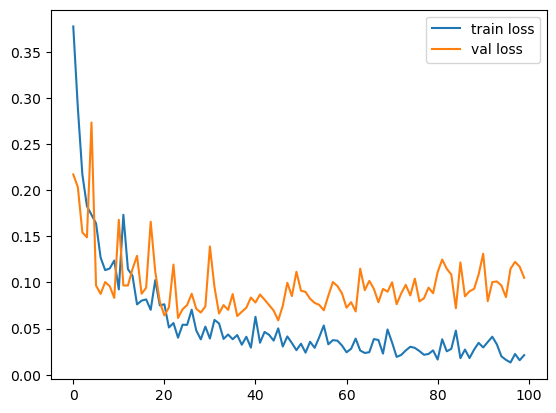

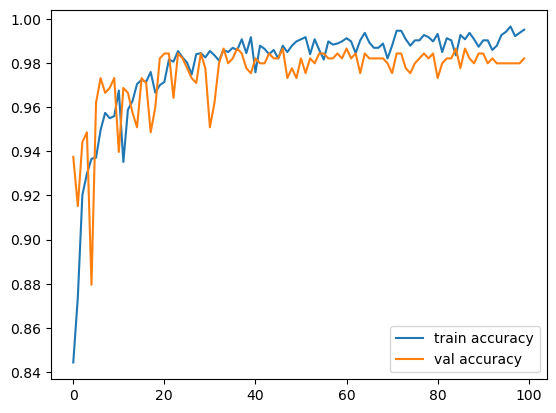

<Figure size 640x480 with 0 Axes>

In [24]:
plt.fig
plt.plot(r3.history['loss'], label='train loss')
plt.plot(r3.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss_resnet')

plt.plot(r3.history['accuracy'], label='train accuracy')
plt.plot(r3.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('LossVal_accuracy_resnet')

In [25]:
model3 = load_model(filepath)

In [26]:
accuracy_cnn2_test = model3.evaluate_generator(generator= testing_set)[1]
accuracy_cnn2_test

C:\Users\kumar\AppData\Local\Temp\ipykernel_11584\3598110899.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_cnn2_test = model3.evaluate_generator(generator= testing_set)[1]


0.9777777791023254

In [28]:
accuracy_cnn2_train = model3.evaluate_generator(generator= training_set)[1]
accuracy_cnn2_train

C:\Users\kumar\AppData\Local\Temp\ipykernel_11584\3276408081.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_cnn2_train = model3.evaluate_generator(generator= training_set)[1]


0.9885714054107666

In [29]:
accuracy_cnn2_val = model3.evaluate_generator(generator= validation_set)[1]
accuracy_cnn2_val

C:\Users\kumar\AppData\Local\Temp\ipykernel_11584\3832802852.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_cnn2_val = model3.evaluate_generator(generator= validation_set)[1]


0.9866666793823242

 # Xception 

In [98]:
image_size = [224, 224]
xception = Xception(input_shape = image_size + [3], include_top = False, weights = 'imagenet')

In [99]:
for layer in inception.layers:
    layer.trainable=False

In [100]:
x = (xception.output)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
prediction=Dense(2, activation='softmax')(x)

model4 = Model(inputs=xception.input, outputs=prediction)

In [101]:
from keras.callbacks import ModelCheckpoint
filepath = 'Xception_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             ave_weights_only=False,
                             mode='max')
callbacks = [checkpoint]

In [102]:
model4.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(0.001),
    metrics=['accuracy']
)

In [103]:
model4.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

 block4_sepconv1_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 28, 28, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 28, 28, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 14, 14, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 14, 14, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_19 (Add)                   (None, 14, 14, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_18[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 14, 14, 728)  0          ['add_19[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 14, 14, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 14, 14, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 14, 14, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 14, 14, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_22 (A

In [65]:
r4 = model4.fit(
    training_set,
    validation_data=validation_set,
    epochs=70,
    steps_per_epoch = training_set.samples//training_set.batch_size,
    validation_steps = validation_set.samples//validation_set.batch_size,
    callbacks=callbacks
)

Epoch 1/70
65/65 [==============================] - ETA: 0s - loss: 0.6922 - accuracy: 0.5426 
Epoch 1: val_accuracy did not improve from 0.66964
65/65 [==============================] - 808s 12s/step - loss: 0.6922 - accuracy: 0.5426 - val_loss: 0.6799 - val_accuracy: 0.6384
Epoch 2/70
65/65 [==============================] - ETA: 0s - loss: 0.6862 - accuracy: 0.5667 
Epoch 2: val_accuracy did not improve from 0.66964
65/65 [==============================] - 848s 13s/step - loss: 0.6862 - accuracy: 0.5667 - val_loss: 0.6964 - val_accuracy: 0.4933
Epoch 3/70
65/65 [==============================] - ETA: 0s - loss: 0.6757 - accuracy: 0.6973 
Epoch 3: val_accuracy did not improve from 0.66964
65/65 [==============================] - 875s 13s/step - loss: 0.6757 - accuracy: 0.6973 - val_loss: 0.6972 - val_accuracy: 0.4978
Epoch 4/70
65/65 [==============================] - ETA: 0s - loss: 0.7006 - accuracy: 0.4985 
Epoch 4: val_accuracy did not improve from 0.66964
65/65 [================

65/65 [==============================] - 785s 12s/step - loss: 0.6950 - accuracy: 0.4836 - val_loss: 0.6956 - val_accuracy: 0.4375
Epoch 31/70
65/65 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.5068 
Epoch 31: val_accuracy did not improve from 0.66964
65/65 [==============================] - 747s 11s/step - loss: 0.6929 - accuracy: 0.5068 - val_loss: 0.6911 - val_accuracy: 0.5625
Epoch 32/70
65/65 [==============================] - ETA: 0s - loss: 0.6891 - accuracy: 0.5938 
Epoch 32: val_accuracy did not improve from 0.66964
65/65 [==============================] - 742s 11s/step - loss: 0.6891 - accuracy: 0.5938 - val_loss: 0.6897 - val_accuracy: 0.5692
Epoch 33/70
65/65 [==============================] - ETA: 0s - loss: 0.6454 - accuracy: 0.6804 
Epoch 33: val_accuracy did not improve from 0.66964
65/65 [==============================] - 743s 11s/step - loss: 0.6454 - accuracy: 0.6804 - val_loss: 0.6886 - val_accuracy: 0.5670
Epoch 34/70
65/65 [=============

65/65 [==============================] - 707s 11s/step - loss: 0.0964 - accuracy: 0.9657 - val_loss: 0.7445 - val_accuracy: 0.5603
Epoch 60/70
65/65 [==============================] - ETA: 0s - loss: 0.1068 - accuracy: 0.9657 
Epoch 60: val_accuracy did not improve from 0.75000
65/65 [==============================] - 700s 11s/step - loss: 0.1068 - accuracy: 0.9657 - val_loss: 0.7264 - val_accuracy: 0.5558
Epoch 61/70
65/65 [==============================] - ETA: 0s - loss: 0.1052 - accuracy: 0.9662 
Epoch 61: val_accuracy did not improve from 0.75000
65/65 [==============================] - 693s 11s/step - loss: 0.1052 - accuracy: 0.9662 - val_loss: 0.6416 - val_accuracy: 0.6674
Epoch 62/70
65/65 [==============================] - ETA: 0s - loss: 0.0569 - accuracy: 0.9932 
Epoch 62: val_accuracy did not improve from 0.75000
65/65 [==============================] - 695s 11s/step - loss: 0.0569 - accuracy: 0.9932 - val_loss: 0.6477 - val_accuracy: 0.5692
Epoch 63/70
65/65 [=============

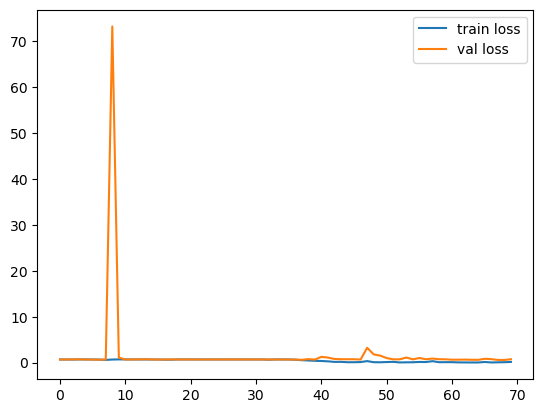

<Figure size 640x480 with 0 Axes>

In [66]:
plt.plot(r4.history['loss'], label='train loss')
plt.plot(r4.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss_xception')
# plt.savefig('LossVal_accuracy_xception')

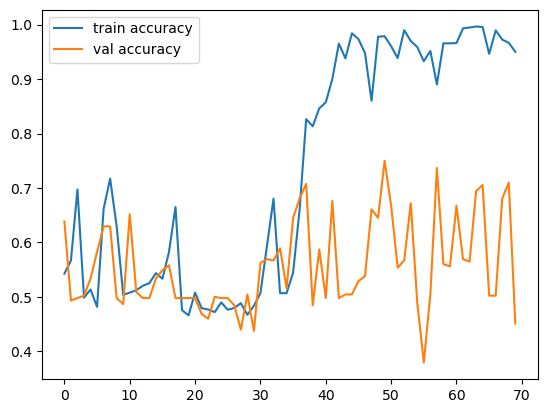

In [67]:
plt.plot(r4.history['accuracy'], label='train accuracy')
plt.plot(r4.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

In [68]:
model4 = load_model(filepath)

In [69]:
accuracy_cnn2_test = model4.evaluate_generator(generator= testing_set)[1]
accuracy_cnn2_test

C:\Users\kumar\AppData\Local\Temp\ipykernel_11584\1461215766.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_cnn2_test = model4.evaluate_generator(generator= testing_set)[1]


0.7488889098167419

In [70]:
accuracy_cnn2_train = model4.evaluate_generator(generator= training_set)[1]
accuracy_cnn2_train

C:\Users\kumar\AppData\Local\Temp\ipykernel_11584\2397060873.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_cnn2_train = model4.evaluate_generator(generator= training_set)[1]


0.6399999856948853

In [71]:
accuracy_cnn2_val = model4.evaluate_generator(generator= validation_set)[1]
accuracy_cnn2_val

C:\Users\kumar\AppData\Local\Temp\ipykernel_11584\3963402458.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_cnn2_val = model4.evaluate_generator(generator= validation_set)[1]


0.7511110901832581

# Densenet

In [104]:
densenet = DenseNet201(input_shape = image_size + [3], include_top = False, weights = 'imagenet')

In [105]:
for layer in densenet.layers:
    layer.trainable=False

In [106]:
filepath = 'densenet_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only = False,
                             mode='max')
callbacks = [checkpoint]

In [107]:
x = (densenet.output)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
prediction=Dense(2, activation='softmax')(x)

model5 = Model(inputs=densenet.input, outputs=prediction)

In [108]:
model5.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(0.001),
    metrics=['accuracy']
)

In [109]:
model5.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_9[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

 conv2_block4_0_relu (Activatio  (None, 56, 56, 160)  0          ['conv2_block4_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)       

 ization)                                                                                         
                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_blo

 conv3_block10_concat (Concaten  (None, 28, 28, 448)  0          ['conv3_block9_concat[0][0]',    
 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
          

                                                                                                  
 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block7_0_relu (Activatio  (None, 14, 14, 448)  0          ['conv4_block7_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)

 ate)                                                             'conv4_block15_2_conv[0][0]']   
                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 14, 14, 1024  4096       ['conv4_block24_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_blo

 conv4_block29_0_bn (BatchNorma  (None, 14, 14, 1152  4608       ['conv4_block28_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block29_0_relu (Activati  (None, 14, 14, 1152  0          ['conv4_block29_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 14, 14, 128)  147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block33_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block33_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block33_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block33_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block33_1_relu[0][0]']   
                                                                                                  
 conv4_block33_concat (Concaten  (None, 14, 14, 1312  0          ['conv4_block32_concat[0][0]',   
 ate)     

 conv4_block37_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block37_1_relu[0][0]']   
                                                                                                  
 conv4_block37_concat (Concaten  (None, 14, 14, 1440  0          ['conv4_block36_concat[0][0]',   
 ate)                           )                                 'conv4_block37_2_conv[0][0]']   
                                                                                                  
 conv4_block38_0_bn (BatchNorma  (None, 14, 14, 1440  5760       ['conv4_block37_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block38_0_relu (Activati  (None, 14, 14, 1440  0          ['conv4_block38_0_bn[0][0]']     
 on)                            )                                                                 
          

                                                                                                  
 conv4_block42_0_relu (Activati  (None, 14, 14, 1568  0          ['conv4_block42_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block42_1_conv (Conv2D)  (None, 14, 14, 128)  200704      ['conv4_block42_0_relu[0][0]']   
                                                                                                  
 conv4_block42_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block42_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block42_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block42_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block46_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block46_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block46_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block46_1_relu[0][0]']   
                                                                                                  
 conv4_block46_concat (Concaten  (None, 14, 14, 1728  0          ['conv4_block45_concat[0][0]',   
 ate)                           )                                 'conv4_block46_2_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 128)    118784      ['conv5_block2_0_relu[0][0]']    
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 128)   512         ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block6_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block6_1_relu[0][0]']    
                                                                                                  
 conv5_block6_concat (Concatena  (None, 7, 7, 1088)  0           ['conv5_block5_concat[0][0]',    
 te)                                                              'conv5_block6_2_conv[0][0]']    
                                                                                                  
 conv5_block7_0_bn (BatchNormal  (None, 7, 7, 1088)  4352        ['conv5_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block7_0_relu (Activatio  (None, 7, 7, 1088)  0           ['conv5_block7_0_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv5_block11_0_relu (Activati  (None, 7, 7, 1216)  0           ['conv5_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block11_1_conv (Conv2D)  (None, 7, 7, 128)    155648      ['conv5_block11_0_relu[0][0]']   
                                                                                                  
 conv5_block11_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_blo

 conv5_block15_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block15_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block15_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block15_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block15_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block15_1_relu[0][0]']   
                                                                                                  
 conv5_block15_concat (Concaten  (None, 7, 7, 1376)  0           ['conv5_block14_concat[0][0]',   
 ate)                                                             'conv5_block15_2_conv[0][0]']   
          

                                                                                                  
 conv5_block19_concat (Concaten  (None, 7, 7, 1504)  0           ['conv5_block18_concat[0][0]',   
 ate)                                                             'conv5_block19_2_conv[0][0]']   
                                                                                                  
 conv5_block20_0_bn (BatchNorma  (None, 7, 7, 1504)  6016        ['conv5_block19_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block20_0_relu (Activati  (None, 7, 7, 1504)  0           ['conv5_block20_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_blo

 conv5_block24_0_relu (Activati  (None, 7, 7, 1632)  0           ['conv5_block24_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block24_1_conv (Conv2D)  (None, 7, 7, 128)    208896      ['conv5_block24_0_relu[0][0]']   
                                                                                                  
 conv5_block24_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block24_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block24_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block24_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv5_block28_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block28_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block28_1_relu[0][0]']   
                                                                                                  
 conv5_block28_concat (Concaten  (None, 7, 7, 1792)  0           ['conv5_block27_concat[0][0]',   
 ate)                                                             'conv5_block28_2_conv[0][0]']   
                                                                                                  
 conv5_block29_0_bn (BatchNorma  (None, 7, 7, 1792)  7168        ['conv5_block28_concat[0][0]']   
 lization)

 ate)                                                             'conv5_block32_2_conv[0][0]']   
                                                                                                  
 bn (BatchNormalization)        (None, 7, 7, 1920)   7680        ['conv5_block32_concat[0][0]']   
                                                                                                  
 relu (Activation)              (None, 7, 7, 1920)   0           ['bn[0][0]']                     
                                                                                                  
 global_average_pooling2d_6 (Gl  (None, 1920)        0           ['relu[0][0]']                   
 obalAveragePooling2D)                                                                            
                                                                                                  
 flatten_6 (Flatten)            (None, 1920)         0           ['global_average_pooling2d_6[0][0
          

In [ ]:


r5 = model5.fit(
    training_set,
    batch_size = 32,
    validation_data=validation_set,
    epochs = 90,
    steps_per_epoch = training_set.samples//training_set.batch_size,
    validation_steps = validation_set.samples//validation_set.batch_size,
    callbacks=callbacks
)

In [ ]:
plt.plot(5.history['loss'], label='train loss')
plt.plot(r5.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss_densenet')

plt.plot(r5.history['accuracy'], label='train accuracy')
plt.plot(r5.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('LossVal_accuracy_densenet')

In [ ]:
model5 = load_model(filepath)

In [ ]:
accuracy_cnn2_test = model5.evaluate_generator(generator= testing_set)[1]
accuracy_cnn2_test

In [ ]:
accuracy_cnn2_train = model5.evaluate_generator(generator= training_set)[1]
accuracy_cnn2_train

In [ ]:
accuracy_cnn2_val = model5.evaluate_generator(generator= validation_set)[1]
accuracy_cnn2_val